In [69]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
from pathlib import Path

import numpy as np
import pandas as pd

from wufam.data.prepare_data import read_kf_data
from wufam.config.trading_config import TradingConfig
from wufam.dataset import Dataset
from wufam.strategies.base_strategy import BaseStrategy
from wufam.backtest.rolling_backtest import run_rolling_backtest
from wufam.metrics.metrics import calc_sharpe

PATH = Path("../data/kf_data")
START = "1970-01-01"
END = "2024-12-31"
DATASET = Dataset.BM_25_D
FACTORS_DATASET = Dataset.FACTORS_D
WEIGHTING = "value_weighted"
FACTOR_ANNUALIZE = 252

## 1.1

In [71]:
portfolios_total_r, portfolios_xs_r, factors_df, rf = read_kf_data(
    portfolios_filename=PATH / DATASET,
    factors_filename=PATH / FACTORS_DATASET,
    start_date=START,
    end_date=END,
    weighting=WEIGHTING,
)

In [72]:
assert (
    portfolios_total_r.shape[0]
    == portfolios_xs_r.shape[0]
    == factors_df.shape[0]
    == rf.shape[0]
)

## 1.2

In [73]:
from wufam.strategies.optimized.min_var import MinVariance

trading_config = TradingConfig(total_exposure=1)

In [74]:
from wufam.estimation.covariance.shrinkage.lw_cv_cov_estimator import (
    LedoitWolfCVCovEstimator,
)

min_var_lw_strategy = MinVariance(
    cov_estimator=LedoitWolfCVCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [75]:
from wufam.strategies.timed.vol_managed_transform import VolManagedTransform

vol_managed_trading_config = TradingConfig(min_exposure=0.0, max_exposure=2.0)

vol_managed_transform = VolManagedTransform(
    trading_config=vol_managed_trading_config,
    vol_window=21,
)

In [76]:
def evaluate_strategy(
    strategy: BaseStrategy, return_weights: bool = False
) -> tuple[float, float] | tuple[float, float, pd.DataFrame]:
    bt_results = run_rolling_backtest(
        strategy=strategy,
        excess_returns=portfolios_xs_r,
        factors=factors_df,
        rf=rf,
        freq="M",
        trading_lag=1,
        return_weights=return_weights,
    )

    if return_weights:
        total_r, turnover, me_weights = bt_results
    else:
        total_r, turnover = bt_results

    sr = calc_sharpe(
        strategy_total_r=total_r,
        rf_rate=rf,
        factor_annualize=FACTOR_ANNUALIZE,
    )

    avg_turnover = turnover.iloc[1:].mean()

    if return_weights:
        return sr, avg_turnover, me_weights

    return sr, avg_turnover

In [77]:
sr, _, transf_weights = evaluate_strategy(
    strategy=vol_managed_transform,
    return_weights=True,
)
sr

Optimizing Strategy: 100%|██████████| 659/659 [00:01<00:00, 650.89it/s] 


0.5398630805684842

In [78]:
transf_weights.shape, portfolios_xs_r.shape

((13851, 25), (13871, 25))

In [79]:
new_assets = transf_weights.iloc[1:] * portfolios_xs_r.iloc[21:]

In [80]:
total_r, turnover, w = run_rolling_backtest(
    strategy=min_var_lw_strategy,
    excess_returns=new_assets,
    factors=factors_df.iloc[21:],
    rf=rf.iloc[21:],
    freq="M",
    trading_lag=1,
    return_weights=True,
)

sr = calc_sharpe(
    strategy_total_r=total_r,
    rf_rate=rf,
    factor_annualize=FACTOR_ANNUALIZE,
)

avg_turnover = turnover.iloc[1:].mean()

sr, avg_turnover

Optimizing Strategy: 100%|██████████| 658/658 [00:05<00:00, 130.96it/s]


(0.8664795037364754, np.float64(0.08365109297672997))

In [81]:
total_r.to_numpy().flatten().shape, rf.iloc[20 * 2 - 1 :].to_numpy().flatten().shape

((13832,), (13832,))

In [82]:
np.corrcoef(total_r.to_numpy().flatten(), rf.iloc[20 * 2 - 1 :].to_numpy().flatten())

array([[1.        , 0.36826082],
       [0.36826082, 1.        ]])

In [83]:
import statsmodels.api as sm

X = rf.iloc[20 * 2 - 1 :].to_numpy().flatten()
y = total_r.to_numpy().flatten()
X = sm.add_constant(X)

res = sm.OLS(y, X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     2170.
Date:                Fri, 08 Aug 2025   Prob (F-statistic):               0.00
Time:                        02:21:29   Log-Likelihood:                 91276.
No. Observations:               13832   AIC:                        -1.825e+05
Df Residuals:                   13830   BIC:                        -1.825e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.982e-05   4.62e-06      4.292      0.000    1.08e-05    2.89e-05
x1             0.9975      0.021     46.581      0.000       0.956       1.040
==============================================================================
Omnibus:                     1839.153   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19655.391
Skew:                          -0.245   Prob(JB):                         0.00
Kurtosis:                       8.819   Cond. No.                     7.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

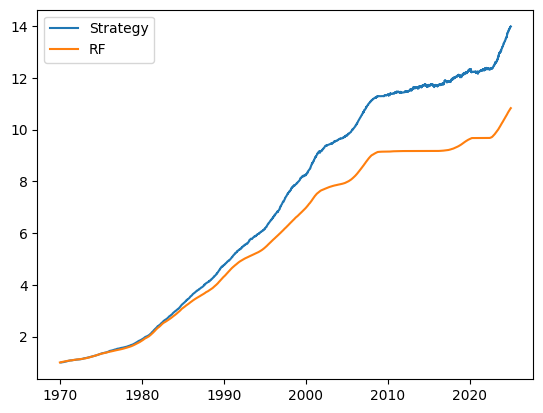

In [84]:
import matplotlib.pyplot as plt

plt.plot(total_r.add(1).cumprod(), label="Strategy")
plt.plot(rf.add(1).cumprod(), label="RF")
plt.legend()
plt.show()

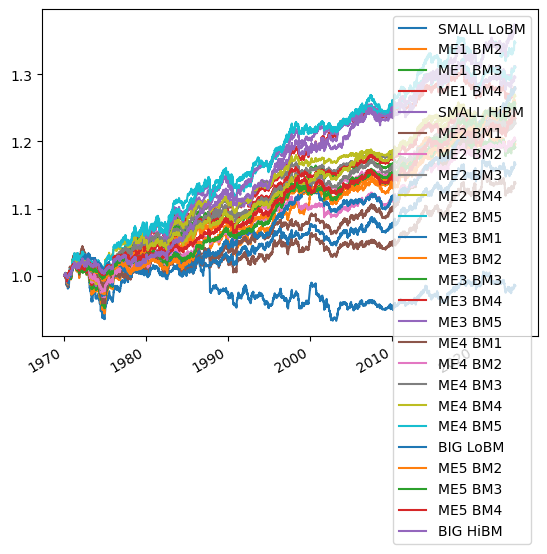

In [85]:
new_assets.add(1).cumprod(axis=0).plot();